In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load embeddings
with open('../data/embeddings.pkl', 'rb') as f:
    data = pickle.load(f)

X_train_emb = data['X_train_emb']
X_val_emb = data['X_val_emb']
X_test_emb = data['X_test_emb']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
label_encoder = data['label_encoder']
embedding_dim = data['embedding_dim']

print(f"Embedding dim: {embedding_dim}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Train: {len(X_train_emb)}, Val: {len(X_val_emb)}, Test: {len(X_test_emb)}")

Using device: cpu
Embedding dim: 384
Number of classes: 5
Train: 1790, Val: 384, Test: 384


In [3]:
class TimelineDataset(Dataset):
    """Dataset for user timelines"""
    
    def __init__(self, embeddings, labels, max_len=50):
        self.embeddings = embeddings
        self.labels = labels
        self.max_len = max_len
    
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        label = self.labels[idx]
        
        # Truncate or pad to max_len
        seq_len = len(emb)
        
        if seq_len > self.max_len:
            emb = emb[:self.max_len]
            seq_len = self.max_len
        
        # Pad with zeros if needed
        if seq_len < self.max_len:
            padding = np.zeros((self.max_len - seq_len, emb.shape[1]))
            emb = np.vstack([emb, padding])
        
        return {
            'embedding': torch.FloatTensor(emb),
            'label': torch.LongTensor([label])[0],
            'seq_len': seq_len  # Actual length before padding
        }

# Create datasets
MAX_LEN = 50

train_dataset = TimelineDataset(X_train_emb, y_train, max_len=MAX_LEN)
val_dataset = TimelineDataset(X_val_emb, y_val, max_len=MAX_LEN)
test_dataset = TimelineDataset(X_test_emb, y_test, max_len=MAX_LEN)

# Create data loaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Test one batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Embedding shape: {sample_batch['embedding'].shape}")
print(f"  Labels shape: {sample_batch['label'].shape}")
print(f"  Seq lengths: {sample_batch['seq_len'][:5]}")

Train batches: 56
Val batches: 12
Test batches: 12

Sample batch:
  Embedding shape: torch.Size([32, 50, 384])
  Labels shape: torch.Size([32])
  Seq lengths: tensor([12,  8,  6,  5, 10])


In [4]:
class BiLSTMAttention(nn.Module):
    """
    BiLSTM with Attention for timeline classification.
    
    Architecture:
    1. BiLSTM processes sequence in both directions
    2. Attention weights which posts are most important
    3. Weighted sum creates fixed-size representation
    4. Classifier predicts mental health category
    """
    
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=2, dropout=0.3):
        super(BiLSTMAttention, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # BiLSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Attention layer
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x, seq_lens=None):
        """
        Args:
            x: (batch_size, max_seq_len, input_dim)
            seq_lens: actual sequence lengths (for masking)
        
        Returns:
            logits: (batch_size, num_classes)
            attention_weights: (batch_size, max_seq_len)
        """
        batch_size, max_len, _ = x.shape
        
        # BiLSTM
        lstm_out, _ = self.lstm(x)  # (batch, max_len, hidden*2)
        
        # Attention scores
        attn_scores = self.attention(lstm_out).squeeze(-1)  # (batch, max_len)
        
        # Mask padding positions (set to -inf so softmax gives 0)
        if seq_lens is not None:
            mask = torch.arange(max_len).expand(batch_size, -1).to(x.device)
            mask = mask >= seq_lens.unsqueeze(1)
            attn_scores = attn_scores.masked_fill(mask, float('-inf'))
        
        # Attention weights
        attn_weights = torch.softmax(attn_scores, dim=1)  # (batch, max_len)
        
        # Weighted sum of LSTM outputs
        context = torch.bmm(attn_weights.unsqueeze(1), lstm_out).squeeze(1)  # (batch, hidden*2)
        
        # Classify
        logits = self.classifier(context)  # (batch, num_classes)
        
        return logits, attn_weights

# Create model
HIDDEN_DIM = 128
NUM_CLASSES = len(label_encoder.classes_)

model = BiLSTMAttention(
    input_dim=embedding_dim,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES,
    num_layers=2,
    dropout=0.3
).to(device)

print("Model architecture:")
print(model)
print()
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture:
BiLSTMAttention(
  (lstm): LSTM(384, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)

Total parameters: 988,166


In [5]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in train_loader:
        embeddings = batch['embedding'].to(device)
        labels = batch['label'].to(device)
        seq_lens = batch['seq_len'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits, _ = model(embeddings, seq_lens)
        
        # Loss
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Store predictions
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, accuracy, f1

def evaluate(model, data_loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            embeddings = batch['embedding'].to(device)
            labels = batch['label'].to(device)
            seq_lens = batch['seq_len'].to(device)
            
            logits, _ = model(embeddings, seq_lens)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, accuracy, f1, all_preds, all_labels

print("Training functions defined!")

Training functions defined!


In [6]:
# Training settings
NUM_EPOCHS = 30
LEARNING_RATE = 0.001

# Loss function (with class weights for imbalance)
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training history
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

best_val_f1 = 0
best_model_state = None

print("Training BiLSTM + Attention Model")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict().copy()
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS}: "
              f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f} | "
              f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

print()
print(f"Best Val F1: {best_val_f1:.4f}")

# Load best model
model.load_state_dict(best_model_state)
print("✓ Loaded best model")

Training BiLSTM + Attention Model
Epoch  1/30: Train Loss=1.1344, Acc=0.6184, F1=0.5564 | Val Loss=0.3453, Acc=0.9062, F1=0.8854
Epoch  5/30: Train Loss=0.1560, Acc=0.9575, F1=0.9463 | Val Loss=0.2056, Acc=0.9479, F1=0.9361
Epoch 10/30: Train Loss=0.1522, Acc=0.9587, F1=0.9474 | Val Loss=0.2360, Acc=0.9245, F1=0.9079
Epoch 15/30: Train Loss=0.0530, Acc=0.9821, F1=0.9771 | Val Loss=0.2438, Acc=0.9453, F1=0.9346
Epoch 20/30: Train Loss=0.0420, Acc=0.9860, F1=0.9841 | Val Loss=0.2396, Acc=0.9531, F1=0.9461
Epoch 25/30: Train Loss=0.0061, Acc=0.9978, F1=0.9972 | Val Loss=0.3794, Acc=0.9505, F1=0.9447
Epoch 30/30: Train Loss=0.0078, Acc=0.9966, F1=0.9960 | Val Loss=0.3123, Acc=0.9453, F1=0.9340

Best Val F1: 0.9518
✓ Loaded best model


In [7]:
# Evaluate on test set
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print("=" * 60)
print("BiLSTM + ATTENTION TEST RESULTS")
print("=" * 60)
print(f"Accuracy: {test_acc:.4f} ({test_acc*100:.1f}%)")
print(f"F1 (macro): {test_f1:.4f}")
print()
print("Classification Report:")
print("-" * 60)
print(classification_report(
    test_labels, 
    test_preds, 
    target_names=label_encoder.classes_
))

BiLSTM + ATTENTION TEST RESULTS
Accuracy: 0.9375 (93.8%)
F1 (macro): 0.9179

Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

        ADHD       0.95      0.88      0.92        69
         OCD       0.97      0.98      0.97       144
   aspergers       0.96      0.94      0.95        85
  depression       0.75      0.94      0.83        32
        ptsd       0.94      0.89      0.91        54

    accuracy                           0.94       384
   macro avg       0.91      0.93      0.92       384
weighted avg       0.94      0.94      0.94       384



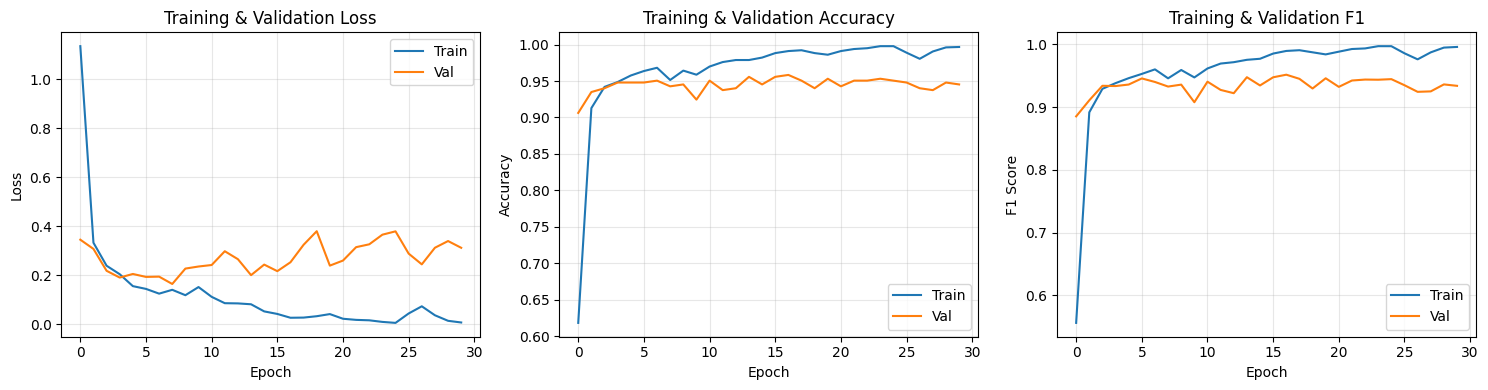

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1
axes[2].plot(history['train_f1'], label='Train')
axes[2].plot(history['val_f1'], label='Val')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Training & Validation F1')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/bilstm_training_history.png', dpi=150)
plt.show()

In [9]:
def evaluate_early_detection_bilstm(model, X_emb, y_true, device, percentages=[0.25, 0.50, 0.75, 1.0]):
    """
    Evaluate BiLSTM using only first X% of each user's timeline.
    """
    model.eval()
    results = {}
    
    for pct in percentages:
        all_preds = []
        
        with torch.no_grad():
            for i, timeline in enumerate(X_emb):
                # Truncate to first pct%
                num_posts = max(1, int(len(timeline) * pct))
                truncated = timeline[:num_posts]
                
                # Pad to max_len
                max_len = 50
                seq_len = len(truncated)
                if seq_len < max_len:
                    padding = np.zeros((max_len - seq_len, truncated.shape[1]))
                    truncated = np.vstack([truncated, padding])
                
                # Convert to tensor
                x = torch.FloatTensor(truncated).unsqueeze(0).to(device)
                seq_lens = torch.LongTensor([seq_len]).to(device)
                
                # Predict
                logits, _ = model(x, seq_lens)
                pred = torch.argmax(logits, dim=1).cpu().numpy()[0]
                all_preds.append(pred)
        
        # Calculate metrics
        acc = accuracy_score(y_true, all_preds)
        f1 = f1_score(y_true, all_preds, average='macro')
        avg_posts = np.mean([max(1, int(len(t) * pct)) for t in X_emb])
        
        results[pct] = {
            'accuracy': acc,
            'f1_macro': f1,
            'avg_posts_used': avg_posts
        }
        
        print(f"{int(pct*100):3d}% history: Accuracy={acc:.4f}, F1={f1:.4f}, Avg posts={avg_posts:.1f}")
    
    return results

print("Early Detection Results - BiLSTM + Attention (Test Set)")
print("=" * 60)
bilstm_early_results = evaluate_early_detection_bilstm(model, X_test_emb, y_test, device)

Early Detection Results - BiLSTM + Attention (Test Set)
 25% history: Accuracy=0.8125, F1=0.7701, Avg posts=2.0
 50% history: Accuracy=0.9115, F1=0.8884, Avg posts=4.4
 75% history: Accuracy=0.9375, F1=0.9225, Avg posts=6.5
100% history: Accuracy=0.9375, F1=0.9179, Avg posts=9.4


In [10]:
# Load baseline results
with open('../results/baseline_results.pkl', 'rb') as f:
    baseline_data = pickle.load(f)
baseline_early = baseline_data['early_detection']

# Create comparison table
print("\n" + "=" * 70)
print("EARLY DETECTION COMPARISON: Baseline vs BiLSTM")
print("=" * 70)
print(f"{'History':<12} {'Baseline Acc':<15} {'BiLSTM Acc':<15} {'Improvement':<12}")
print("-" * 70)

for pct in [0.25, 0.50, 0.75, 1.0]:
    base_acc = baseline_early[pct]['accuracy']
    bilstm_acc = bilstm_early_results[pct]['accuracy']
    improvement = bilstm_acc - base_acc
    
    print(f"{int(pct*100):3d}%         {base_acc*100:>6.1f}%         {bilstm_acc*100:>6.1f}%         {improvement*100:>+5.1f}%")

print("-" * 70)


EARLY DETECTION COMPARISON: Baseline vs BiLSTM
History      Baseline Acc    BiLSTM Acc      Improvement 
----------------------------------------------------------------------
 25%           84.1%           81.2%          -2.9%
 50%           92.4%           91.1%          -1.3%
 75%           91.7%           93.8%          +2.1%
100%           93.0%           93.8%          +0.8%
----------------------------------------------------------------------


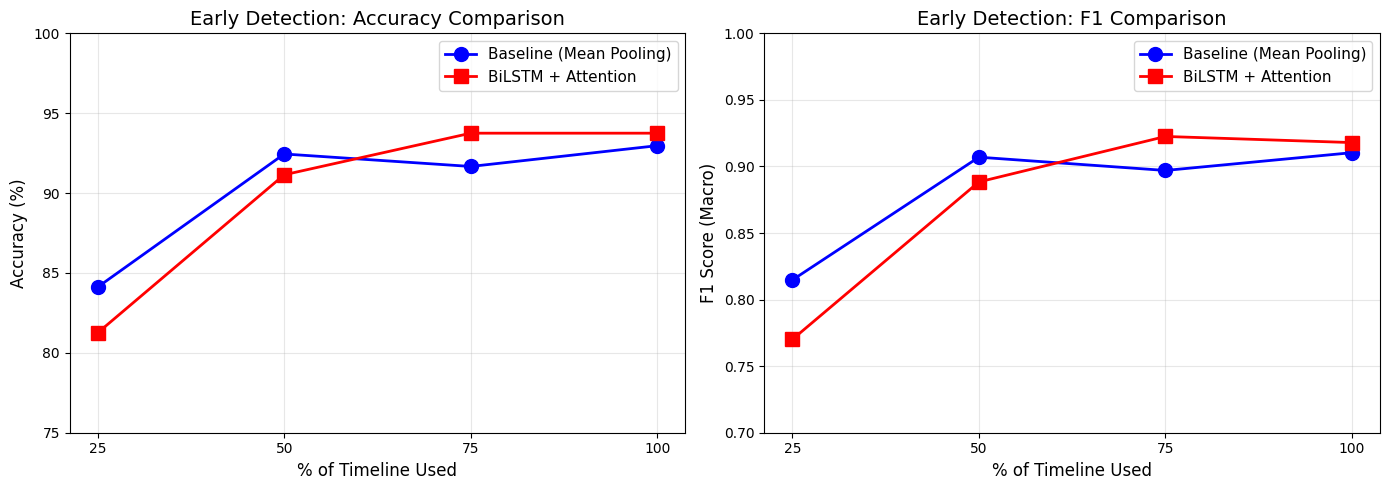

✓ Saved to results/early_detection_comparison.png


In [11]:
percentages = [0.25, 0.50, 0.75, 1.0]

baseline_accs = [baseline_early[p]['accuracy'] * 100 for p in percentages]
bilstm_accs = [bilstm_early_results[p]['accuracy'] * 100 for p in percentages]

baseline_f1s = [baseline_early[p]['f1_macro'] for p in percentages]
bilstm_f1s = [bilstm_early_results[p]['f1_macro'] for p in percentages]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
x = [25, 50, 75, 100]
axes[0].plot(x, baseline_accs, 'b-o', label='Baseline (Mean Pooling)', linewidth=2, markersize=10)
axes[0].plot(x, bilstm_accs, 'r-s', label='BiLSTM + Attention', linewidth=2, markersize=10)
axes[0].set_xlabel('% of Timeline Used', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Early Detection: Accuracy Comparison', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].set_xticks(x)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([75, 100])

# F1 comparison
axes[1].plot(x, baseline_f1s, 'b-o', label='Baseline (Mean Pooling)', linewidth=2, markersize=10)
axes[1].plot(x, bilstm_f1s, 'r-s', label='BiLSTM + Attention', linewidth=2, markersize=10)
axes[1].set_xlabel('% of Timeline Used', fontsize=12)
axes[1].set_ylabel('F1 Score (Macro)', fontsize=12)
axes[1].set_title('Early Detection: F1 Comparison', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].set_xticks(x)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.7, 1.0])

plt.tight_layout()
plt.savefig('../results/early_detection_comparison.png', dpi=150)
plt.show()

print("✓ Saved to results/early_detection_comparison.png")

In [12]:
# Save model and results
torch.save(model.state_dict(), '../results/bilstm_model.pth')

bilstm_results = {
    'model_name': 'BiLSTM + Attention',
    'test_accuracy': test_acc,
    'test_f1': test_f1,
    'early_detection': bilstm_early_results,
    'history': history
}

with open('../results/bilstm_results.pkl', 'wb') as f:
    pickle.dump(bilstm_results, f)

print("✓ Saved model to results/bilstm_model.pth")
print("✓ Saved results to results/bilstm_results.pkl")

✓ Saved model to results/bilstm_model.pth
✓ Saved results to results/bilstm_results.pkl
